In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import statistics
import xgboost as xgb
from custom_xgboost import CustomXGBoost
from custom_decision_tree import CustomDecisionTree
from custom_hist_gradient_boosting import CustomHGBoosting
from custom_random_forest import CustomRandomForest
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from custom_functions import cross_val_data
from sklearn.model_selection import GridSearchCV

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [9]:
# Importing the dataset
file_path = 'P:\DATA_OCT_22\Expert_Eye\Dataset\Data\data_v8.csv'
df = pd.read_csv(file_path)
dataset = df.copy()
dataset.head()

,Gender,VINCQ32DDN,VINICODEX003,FROPCOM0001,FROPCOM0005,FROPCOM0006_S1_,FROPCOM0006_S2_,FROPCOM0006_S3_,FROPCOM0006_S4_,FROPCOM0006_S5_,...,FROPCOM0004_SQ010_SQ002__100_mg,FROPCOM0004_SQ010_SQ002__20_mg,FROPCOM0004_SQ010_SQ002__nan,FROPCOM0004_SQ010_SQ003__0_5_0_0,FROPCOM0004_SQ010_SQ003__1_0_0,FROPCOM0004_SQ010_SQ003__1_0_1,FROPCOM0004_SQ010_SQ003__10_0_0,FROPCOM0004_SQ010_SQ003__nan,Frailty_Score,Frailty_State
0,0,76.0,0.0,0.0,3.0,NaN,NaN,NaN,NaN,1.0,...,0,0,1,0,0,0,0,1,7,0
1,0,75.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,4,1
2,0,67.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,9,0
3,0,72.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,0,1,7,0
4,1,69.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,8,0


In [3]:
# missing values
missing = dataset.isnull().sum() 

# droping the columns with more than more than 10 missing values
remain_df = dataset.iloc[:, missing.values < 10]

remain_df.shape

In [7]:
# droping the rows with missing values
remain_df = remain_df.dropna()
remain_df.shape

(78, 587)

In [5]:
estimator = HistGradientBoostingClassifier()
models = {
    'XGBoost': CustomXGBoost(),
    'RandomForest': CustomRandomForest(max_features=0.5, class_weight={0: 71, 1: 26}),
}

In [7]:
# Initialize an empty dictionary to hold the metrics
model_metrics = {}
n_splits = 2 # Number of folds

for X_train, X_test, y_train, y_test in cross_val_data(dataset, n_splits):

    # Train models
    for model_name, model in models.items():
        # Initialize the metrics for the current model if not already done
        if model_name not in model_metrics:
            model_metrics[model_name] = {
                'test_acc': [],
                'test_f1': [],
                'test_prec': [],
                'test_rec': [],
                'test_roc_auc': []
            }

        model.fit(X_train, y_train)
        
        # Predictions
        y_test_pred = model.predict(X_test)
        
        # Calculate metrics
        model_metrics[model_name]['test_acc'].append(accuracy_score(y_test, y_test_pred))
        model_metrics[model_name]['test_f1'].append(f1_score(y_test, y_test_pred, average='weighted'))
        model_metrics[model_name]['test_prec'].append(precision_score(y_test, y_test_pred, average='weighted'))
        model_metrics[model_name]['test_rec'].append(recall_score(y_test, y_test_pred, average='weighted'))
        model_metrics[model_name]['test_roc_auc'].append(roc_auc_score(y_test, y_test_pred))

# Calculate average and std metrics over all folds
for model_name in models.keys():
    for metric in model_metrics[model_name]:
        average_metric = sum(model_metrics[model_name][metric]) / n_splits
        std_metric = statistics.stdev(model_metrics[model_name][metric]) if len(model_metrics[model_name][metric]) > 1 else 0.0
        model_metrics[model_name][metric] = {'average': average_metric, 'std': std_metric}

# Display metrics
for model_name, metrics in model_metrics.items():
    print(f"Model: {model_name}")
    for metric, values in metrics.items():
        print(f"Average {metric}: {values['average']}, {values['std']}")
        print("=" * 30)

Model: XGBoost
Average test_acc: 0.7004676870748299, 0.07726464403271367
Average test_f1: 0.6947257612599664, 0.07563444620743619
Average test_prec: 0.6906103699454264, 0.07560045185529833
Average test_rec: 0.7004676870748299, 0.07726464403271367
Average test_roc_auc: 0.600442612942613, 0.08610039530381992
Model: RandomForest
Average test_acc: 0.9283588435374149, 0.07185311254404117
Average test_f1: 0.9213949816112793, 0.08131972925963793
Average test_prec: 0.937394551074398, 0.059893103025976335
Average test_rec: 0.9283588435374149, 0.07185311254404117
Average test_roc_auc: 0.8653846153846154, 0.13598207330510537
Model: HistGradientBoostingClassifier
Average test_acc: 0.721938775510204, 0.039684564250265425
Average test_f1: 0.6948709319681393, 0.03888732199449521
Average test_prec: 0.6894288203086112, 0.048703783398053015
Average test_rec: 0.721938775510204, 0.039684564250265425
Average test_roc_auc: 0.5784645909645909, 0.04599647590685378


In [35]:
param_grids = {
    'RandomForest': {
        'n_estimators': [10, 30, 50],
        'max_samples': [0.5, 1.0],
        'max_features': [0.5, 1.0],
        
    },
    'XGBoost': {
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 10]
    }
}


In [ ]:
# For RandomForest
rf_model = CustomRandomForest(random_state=42)
rf_grid_search = GridSearchCV(rf_model, param_grids['RandomForest'], cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train, y_train)

# For XGBoost
xgb_model = CustomXGBoost(eval_metric='logloss', random_state=42)
xgb_grid_search = GridSearchCV(xgb_model, param_grids['XGBoost'], cv=5, scoring='roc_auc', n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)


In [8]:
# For RandomForest
print("Best parameters for RandomForest: ", rf_grid_search.best_params_)
print("Best recall score for RandomForest: ", rf_grid_search.best_score_)

# For XGBoost
print("Best parameters for XGBoost: ", xgb_grid_search.best_params_)
print("Best ROC AUC score for XGBoost: ", xgb_grid_search.best_score_)


Best parameters for XGBoost:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Best ROC AUC score for XGBoost:  nan


In [9]:
feature_names = list(dataset.drop(columns=['Frailty_State', 'Frailty_Score'], axis=1).columns)

In [10]:
# Convert X_train and X_test back to DataFrames with the appropriate column names
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)
y_train_df = pd.DataFrame(y_train, columns=['Frailty_State'])
y_test_df = pd.DataFrame(y_test, columns=['Frailty_State'])

X_train_df.head()

,Gender,VINCQ32DDN,VINICODEX003,FROPCOM0001,FROPCOM0005,FROPCOM0006_S1_,FROPCOM0006_S2_,FROPCOM0006_S3_,FROPCOM0006_S4_,FROPCOM0006_S5_,...,FROPCOM0004_SQ010_SQ001__nan,FROPCOM0004_SQ010_SQ002__100 UI/ml,FROPCOM0004_SQ010_SQ002__100 mg,FROPCOM0004_SQ010_SQ002__20 mg,FROPCOM0004_SQ010_SQ002__nan,FROPCOM0004_SQ010_SQ003__0.5-0-0,FROPCOM0004_SQ010_SQ003__1-0-0,FROPCOM0004_SQ010_SQ003__1-0-1,FROPCOM0004_SQ010_SQ003__10-0-0,FROPCOM0004_SQ010_SQ003__nan
0,0.0,76.0,0.0,0.0,3.0,NaN,NaN,NaN,NaN,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,72.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.0,69.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,74.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,72.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


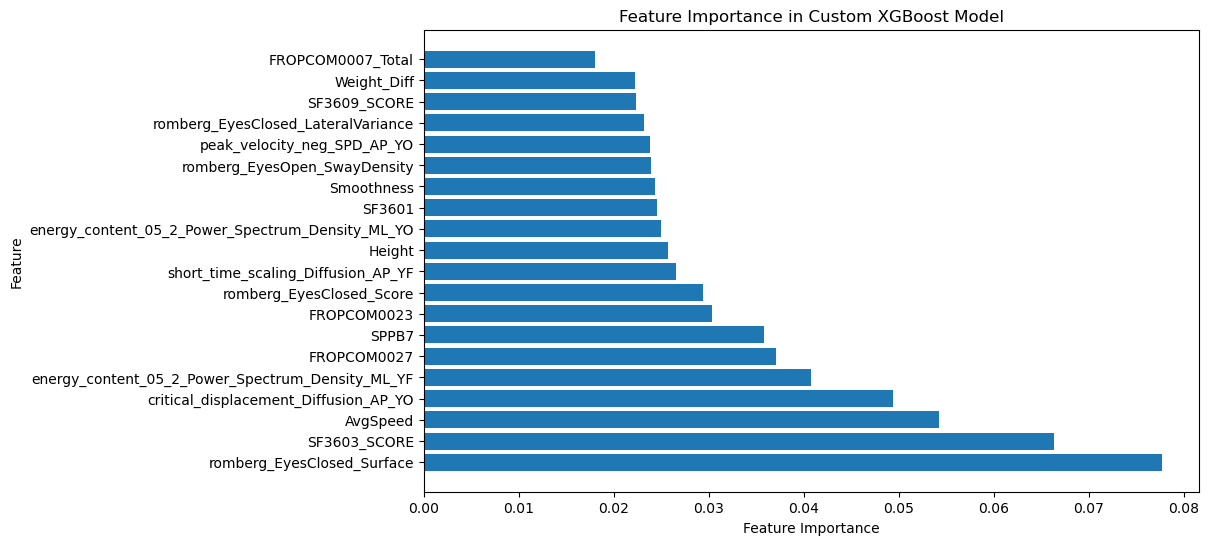

In [11]:
model.fit(X_train_df, y_train_df)
model.plot_feature_importances(X_train_df.columns)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


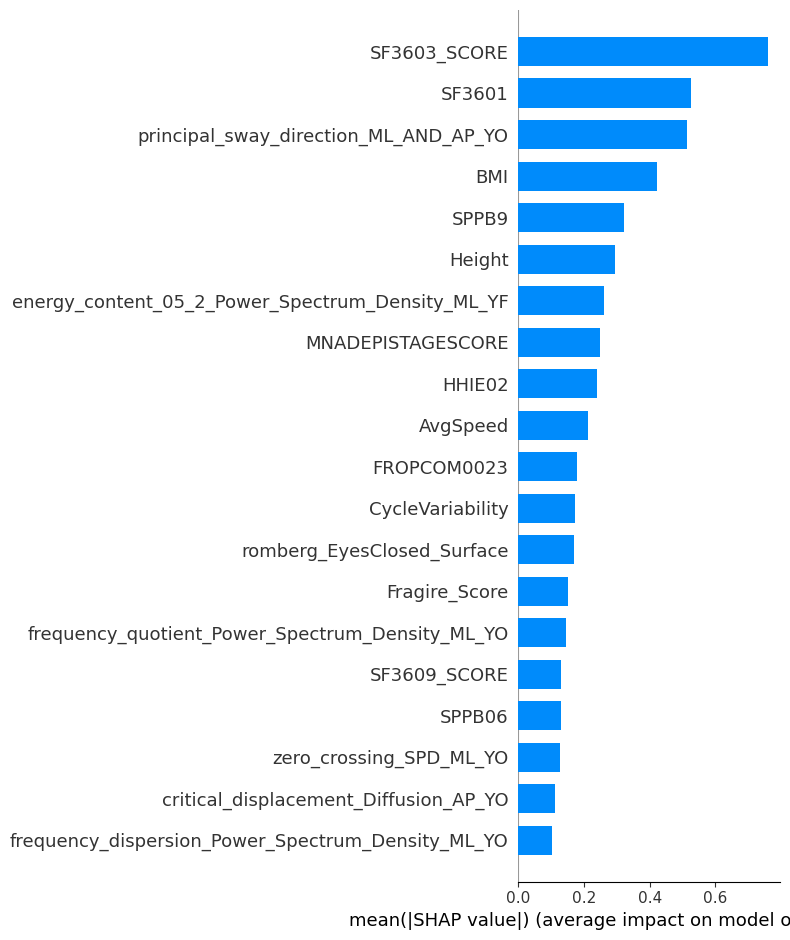

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


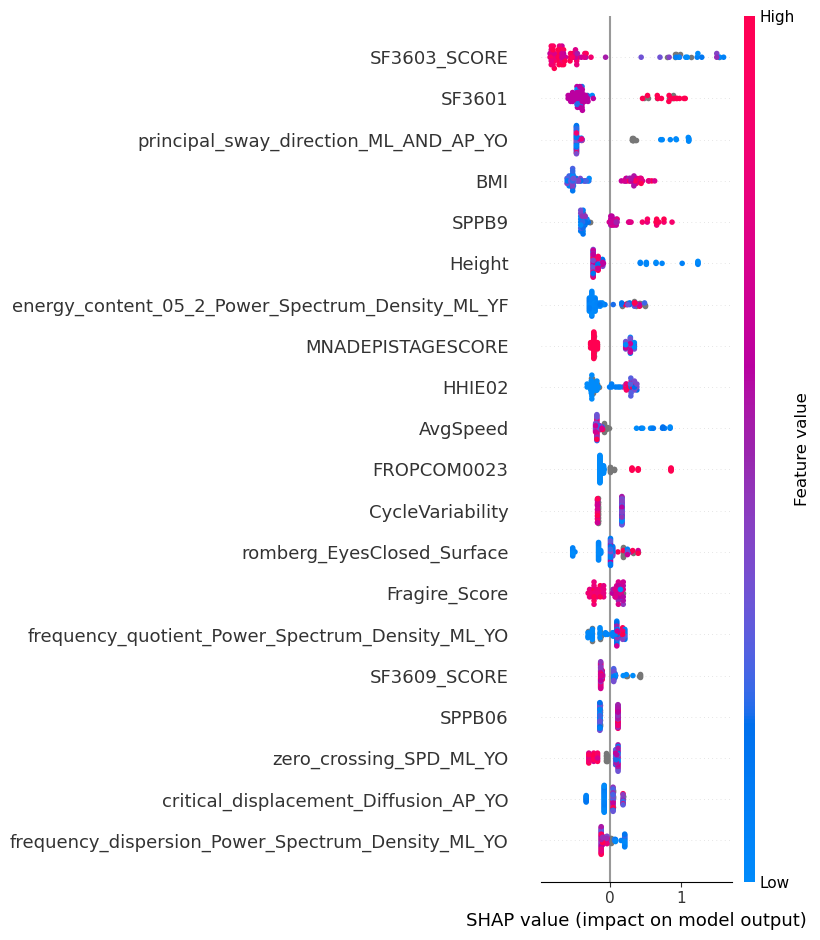

In [12]:
import shap
model = xgb.XGBClassifier()
model.fit(X_train_df, y_train_df)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_df)

shap.summary_plot(shap_values, X_train_df, plot_type="bar")

shap.summary_plot(shap_values, X_train_df)
